![logo](../../../LogoLine_horizon_C3S.png)

# Utility of the Randolph Glacier Inventory (RGI) for regional and global glacier volume estimates

Production date: 31-05-2025

Dataset version: 6.0

Produced by: Yoni Verhaegen and Philippe Huybrechts (Vrije Universiteit Brussel)

## 🌍 Use case: Using delineated glacier outlines and glacier extent data around the year 2000 for the estimation of the corresponding regional and global glacier ice volumes

## ❓ Quality assessment question
**"What is the temporal distribution of the delineated glacier outlines, nominally provided for the year 2000, and how well can they be used to estimate regional and global glacier ice volumes?"**

Glaciers are a major contributor to current global sea-level rise, a resource of fresh water, a potential threat of natural hazards, and an important factor for hydro-power production, recreation and tourism. A proper assessment of glacier areas, glacier characteristics, as well as their changes due to warming climatic conditions therefore plays a crucial role in dealing with these issues. In that regard, the "[Glaciers distribution data from the Randolph Glacier Inventory (RGI) for year 2000](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview)" dataset on the Climate Data Store (CDS) provides key information with respect to glacier extent and their characteristics. The RGI dataset is a collection of digital glacier and ice cap outlines at the global scale, nominally provided for the year 2000 [[1](https://www.glims.org/RGI/randolph60.html), [2](https://doi.org/10.3189/2014JoG13J176)]. The data are available in both vector (a shapefile with polygons of individual glacier outlines) and raster (as gridded data with the aggregated fractional glacier areas per pixel) format. Although the goal of the dataset is to provide glacier outlines of all glaciers on Earth as close as possible to the year 2000, one of the main known issues of the dataset is the fact that the acquisition date of the delineated glacier data varies substantially. This notebook investigates the corresponding temporal distribution of delineated glacier data in the vector version of the dataset and evaluates its implications for the estimation of current global glacier ice volumes using the examples of Farinotti et al. (2019) [[3](https://doi.org/10.1038/s41561-019-0300-3)] and GlaMBIE (2025) [[14](https://doi.org/10.1038/s41586-024-08545-z)]. Since both studies made use of the RGIv6.0, we also use this version in our notebook.

## 📢 Quality assessment statements

```{admonition} These are the key outcomes of this assessment
:class: note
- The RGI dataset, available on the Climate Data Store, is the most comprehensive source of digital glacier area data and provides consistent, static glacier outlines for climatological, hydrological, and glaciological applications at regional to global scales. It holds a snapshot of global glacier area data that is assumed to be representative for the year 2000. However, in reality there is a variation in delineation dates (a certain amount of glaciers were delineated before or after the year 2000). The acquired glacier outlines that deviate from the year 2000 can lead to systematic errors that are apparant for certain applications, such as the use of RGI glacier outlines as input for regional/global glacier volume estimates. 
- Nevertheless, the assessment reveals that the (area-weighted) mean acquisition date of all glacier outlines in the dataset is relatively close to 2000, and that the systematic error at the global scale is relatively small compared to the total glacier volume estimates from the glacier community. This makes the dataset reliable to be used as input data for regional and global glacier volume estimates. However, regional and glacier-specific errors can vary significantly due to factors like strongly deviating delineation dates in some areas, varying spatial glacier mass loss rates and glacier response times, and the presence of a supraglacial debris cover (which may cause significant omission errors in glacierized areas). Users should carefully evaluate these factors for specific applications.
```

## 📋 Methodology

### Dataset description

The dataset of the glaciers distribution on the Climate Data Store (CDS) is an almost complete collection of digital glacier and ice cap outlines and their geometrical/hypsometrical characteristics from various data sources at the global scale [[1](https://www.glims.org/RGI/randolph60.html), [2](https://doi.org/10.3189/2014JoG13J176)]. The RGI dataset on the CDS is considered a snapshot of glacier outlines around the year 2000, assembled mainly from satellite images, and is currently the most complete dataset of glacier outlines. Simply stated, the glaciers in the dataset were automatically classified using the distinctive spectral reflectance signatures of bedrock and ice. During post-processing, raw glacier outlines are quality checked and manually corrected if required (e.g. in the case of a supraglacial debris cover). The vector part of the dataset divides the glaciers into separate RGI regions, i.e. there are 19 of those regions ("clusters" of glaciers) in RGIv6.0. The raster version of the data contains aggregated fractional glacier areas for each pixel of 1 by 1 degree but does not provide sufficient information to classify glaciers into distinct RGI regions. For a more detailed description of the data acquisition and processing methods, we refer to the [documentation on the CDS](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/display/CKB/Glacier+Area) (Copernicus Knowledge Base).

### Structure and (sub)sections

**[](satellite_insitu-glaciers-extent_uncertainty_q01:section-1)**

* [](satellite_insitu-glaciers-extent_uncertainty_q01:section-1-1)
* [](satellite_insitu-glaciers-extent_uncertainty_q01:section-1-2)
* [](satellite_insitu-glaciers-extent_uncertainty_q01:section-1-3)
  
**[](satellite_insitu-glaciers-extent_uncertainty_q01:section-2)**
* [](satellite_insitu-glaciers-extent_uncertainty_q01:section-2-1)
* [](satellite_insitu-glaciers-extent_uncertainty_q01:section-2-2)
* [](satellite_insitu-glaciers-extent_uncertainty_q01:section-2-3)

**[](satellite_insitu-glaciers-extent_uncertainty_q01:section-3)**
* [](satellite_insitu-glaciers-extent_uncertainty_q01:section-3-1)
* [](satellite_insitu-glaciers-extent_uncertainty_q01:section-3-2)
* [](satellite_insitu-glaciers-extent_uncertainty_q01:section-3-3)
  
**[](satellite_insitu-glaciers-extent_uncertainty_q01:section-4)**

## 📈 Analysis and results

(satellite_insitu-glaciers-extent_uncertainty_q01:section-1)=
### 1. Data preparation and processing

(satellite_insitu-glaciers-extent_uncertainty_q01:section-1-1)=
#### 1.1 Import packages

First we load the packages:

In [121]:
import fsspec
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import regionmask
import cartopy.crs as ccrs
import math
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import MultipleLocator
import numpy as np
import xesmf as xe
import matplotlib.patches as mpatches
import xarray as xr
from scipy.optimize import curve_fit
import os
from c3s_eqc_automatic_quality_control import download
plt.style.use("seaborn-v0_8-notebook")

(satellite_insitu-glaciers-extent_uncertainty_q01:section-1-2)=
#### 1.2 Define request and download

Then we define requests for download from the CDS:

🚨 **The files can be large! Since the data files to be downloaded and manipulated have a considerable size, this may take a couple of minutes.**\
🚨 **Insert the correct RGI version number to be downloaded below:**

In [122]:
########## SELECT THE RGI VERSION TO DOWNLOAD #############
rgi_version = 6.0  # Change this as needed
###########################################################

# Select correct column names based on RGI version
if rgi_version == 6.0:
    lon_col, lat_col = "CENLON", "CENLAT"
elif rgi_version == 7.0:
    lon_col, lat_col = "cenlon", "cenlat"
else:
    raise ValueError("Unsupported RGI version.")

# Glacier extent data

request_extent = (
    "insitu-glaciers-extent",
    {
        "variable": ["glacier_area"],
        "product_type": ["vector"],
        "version": f"rgi_{int(rgi_version)}_0"
    },
)

# Glacier mass change data

period_start = "1975_1976"
period_stop = "2021_2022"
assert all("_" in period and len(period) == 9 for period in (period_start, period_stop))
# Set request
y0_start, y1_start = map(int, period_start.split("_"))
y0_stop, y1_stop = map(int, period_stop.split("_"))
collection_id = "derived-gridded-glacier-mass-change"
request = {
    "variable": "glacier_mass_change",
    "product_version": "wgms_fog_2023_09",
    "format": "zip",
    "hydrological_year": [
        f"{y0}_{str(y1)[-2:]}"
        for y0, y1 in zip(range(y0_start, y0_stop + 1), range(y1_start, y1_stop + 1))
    ],
}

Next, we download the data:

In [123]:
# Get glacier extent data: takes a couple of minutes

print("Downloading and handling glacier extent data from the CDS, this may take a couple of minutes...")
df = download.download_and_transform(*request_extent).to_pandas()
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
    crs="EPSG:4326",
)

# Download glacier mass change data
print("Downloading glacier mass change data...")

ds = download.download_and_transform(
    collection_id,
    request,
)

print("Downloading done.")

100%|██████████| 1/1 [00:00<00:00, 67.66it/s]
                                             

100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


We define the functions to be used:

In [124]:
def plot_map(gdf, var_name=None, label=None, title=None, **kwargs):
    fig = plt.figure(figsize=(20,10))
    kwargs = {"markersize": 1, "legend": var_name is not None} | kwargs
    if var_name:
        kwargs = {"c": var_name, "column": var_name} | kwargs
        if var_name == "year":
            kwargs.setdefault("legend_kwds", {"shrink": 0.49, "extend": "both"})
        if label is not None and var_name == "year":
            kwargs["legend_kwds"].setdefault("label", label)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND,color='w')
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gdf.plot(ax=ax, **kwargs)
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=18)
    return ax

def weighted_average(df, field_name, weights_name):
    df = df[df[field_name].notnull() & df[weights_name].notnull()]
    weights = df[weights_name]
    return (df[field_name] * weights).sum() / weights.sum()

def myExpFunc(x, a, b):
    return a * np.power(x, b)

(satellite_insitu-glaciers-extent_uncertainty_q01:section-1-3)=
#### 1.3 Display and inspect data

Lastly, we can read and inspect the data. Let us print out the data to inspect its structure:

In [125]:
df

,C3S_ID,RGIID,GLIMSID,BGNDATE,ENDDATE,CENLON,CENLAT,O1REGION,O2REGION,AREA,ZMIN,ZMAX,ZMED,SLOPE,ASPECT,LMAX,NAME,geometry
index,,,,,,,,,,,,,,,,,,
0,C3S_000001,RGI60-01.00001,G213177E63689N,20090703,-9999999,-146.8230,63.6890,1,2,0.360,1936,2725,2385,42.0,346,839,None,"POLYGON ((-146.81804 63.69081, -146.81768 63.6..."
1,C3S_000002,RGI60-01.00002,G213332E63404N,20090703,-9999999,-146.6680,63.4040,1,2,0.558,1713,2144,2005,16.0,162,1197,None,"POLYGON ((-146.66354 63.40764, -146.66344 63.4..."
2,C3S_000003,RGI60-01.00003,G213920E63376N,20090703,-9999999,-146.0800,63.3760,1,2,1.685,1609,2182,1868,18.0,175,2106,None,"POLYGON ((-146.07232 63.38348, -146.07232 63.3..."
3,C3S_000004,RGI60-01.00004,G213880E63381N,20090703,-9999999,-146.1200,63.3810,1,2,3.681,1273,2317,1944,19.0,195,4175,None,"POLYGON ((-146.14895 63.37919, -146.14881 63.3..."
4,C3S_000005,RGI60-01.00005,G212943E63551N,20090703,-9999999,-147.0570,63.5510,1,2,2.573,1494,2317,1914,16.0,181,2981,None,"POLYGON ((-147.04307 63.55024, -147.04483 63.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216424,C3S_216425,RGI60-19.02748,G322268E53986S,20020502,-9999999,-37.7325,-53.9860,19,3,0.042,310,510,-999,29.9,315,255,None,"POLYGON ((-37.73275 -53.98779, -37.73328 -53.9..."
216425,C3S_216426,RGI60-19.02749,G323864E54831S,20030207,-9999999,-36.1361,-54.8310,19,3,0.567,330,830,-999,23.6,200,1130,None,"POLYGON ((-36.13834 -54.82735, -36.13826 -54.8..."
216426,C3S_216427,RGI60-19.02750,G322698E54188S,20030207,-9999999,-37.3018,-54.1884,19,3,4.118,10,1110,-999,16.8,308,4329,None,"POLYGON ((-37.29309 -54.17506, -37.29308 -54.1..."


As can be seen above, the data includes attribute information for each individual glacier (i.e. delineated polygon) in the vector-type dataset. Important for this notebook are the `BGNDATE` and `ENDDATE` columns (for version 6.0) or `src_date` (for version 7.0), which contain information about the time of delineation of the specific glacier. If for some glaciers (part of) the attributes are missing, the data are filled by `-9999999`. We will use this information below.

(satellite_insitu-glaciers-extent_uncertainty_q01:section-2)=
### 2. The (area-weighted) mean year of delineation of glacier data

(satellite_insitu-glaciers-extent_uncertainty_q01:section-2-1)=
#### 2.1 Determination of date of delineation for every glacier

We can begin to answer the user question by extracting information from the attribute table of the downloaded shapefile. For some glaciers the delineation of the outline is composed from several scenes over multiple years in v6.0, implying that a begin date (attribute "`BGNDATE`") and an end date (attribute "`ENDDATE`") of the outline delineation is given in the attribute table in YYYYMMDD format (if both are available). For v7.0, the acquisition or delineation date is simply given by "`src_date`" in YYYY-MM-DD format: 

$
year_t = \textstyle\dfrac{BGNDATE_t + ENDDATE_t}{2}\ 
$ (version 6.0), or

$
year_t = srcdate_t
$ (version 7.0)

This results in the following plot:

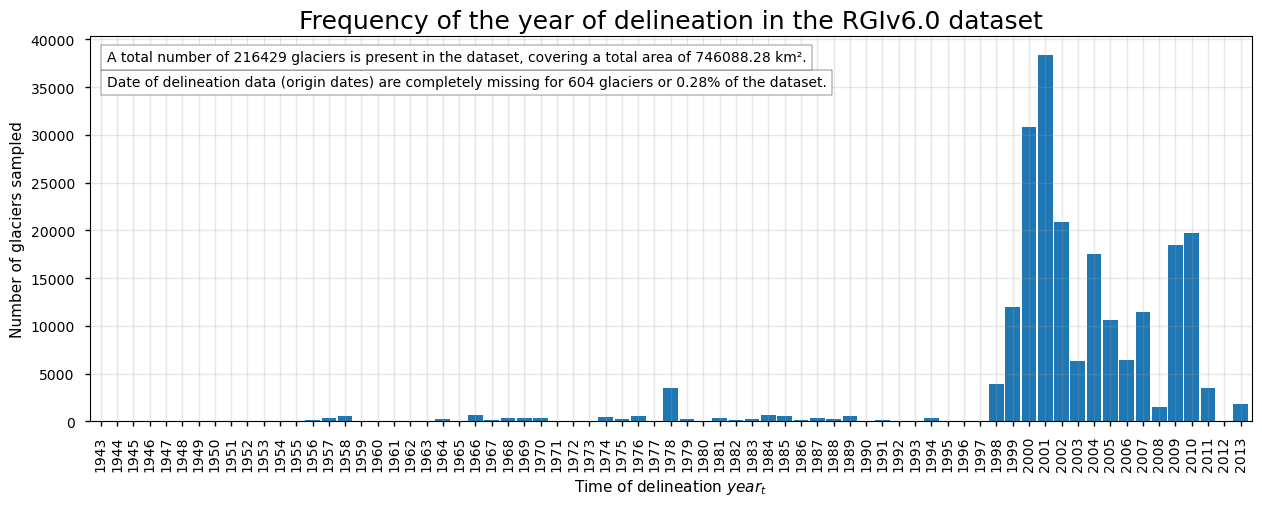

In [126]:
# Convert dates from string to datetime, and add digitalization year
columns = []
if rgi_version == 6.0:
    for column in ("BGNDATE", "ENDDATE"):
        years = gdf[column].str[:4]
        months = gdf[column].str[4:6].replace("99", "01")
        days = gdf[column].str[6:8].replace("99", "01")
        date = years + months + days
        date = date.where(~date.str.startswith("-"))
        columns.append(pd.to_datetime(date))
elif rgi_version == 7.0:
    for column in ["src_date"]:
        years = gdf[column].str[:4]
        months = gdf[column].str[5:7].replace("99", "01")
        days = gdf[column].str[8:10].replace("99", "01")
        date = years + months + days
        date = date.where(~date.str.startswith("-"))
        columns.append(pd.to_datetime(date))
dates = pd.DataFrame(columns).mean()
year = dates.dt.year.astype("Int64")
gdf["decimal_year"] = year + (dates.dt.dayofyear - 1) / (365 + dates.dt.is_leap_year)
gdf["year"] = year

# Get data from years
size = gdf.set_index("year").groupby("year").size()
size = size.reindex(range(gdf["year"].min(), gdf["year"].max() + 1), fill_value=0)
missing = gdf["year"].isnull().sum()
missing_perc = 100 * (missing / len(gdf["year"]))
# Get some statistics
n_glaciers = len(gdf)
if rgi_version == 6.0:
    total_area = gdf["AREA"].sum()
elif rgi_version == 7.0:
    total_area = gdf["area_km2"].sum()
# Plot data
ax = size.plot.bar(
    figsize=(15, 5),
    grid=True,
    width=0.9,
    ylabel="Number of glaciers sampled",
    xlabel=r"Time of delineation $year_t$",
)
_ = ax.text(
    0.015,
    0.87,
    f"Date of delineation data (origin dates) are completely missing for {missing} glaciers or {missing_perc:.2f}% of the dataset.",
    transform=ax.transAxes,
    bbox={"facecolor": "white", "edgecolor": "black"},
);
_ = ax.text(
    0.015,
    0.935,
    f"A total number of {n_glaciers} glaciers is present in the dataset, covering a total area of {total_area:.2f} km².",
    transform=ax.transAxes,
    bbox={"facecolor": "white", "edgecolor": "black"},
);
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_title("Frequency of the year of delineation in the RGIv{} dataset".format(rgi_version), fontsize=18);

*<center>Figure 1. Time of delineation (date of acquisition) for the glaciers in the glacier extent dataset.</center>*

Let us calculate the percentage of years between some specific periods centered around the year 2000 to stronger emphasize that the large temporal deviations from the year 2000 are not frequent:

In [127]:
n_total = year.notna().sum()
pct_1990_2010 = (
    year.between(1990, 2010).sum() / n_total * 100
)
pct_1995_2005 = (
    year.between(1995, 2005).sum() / n_total * 100
)
sentence = (
    f"In the RGIv{rgi_version} dataset, "
    f"{pct_1990_2010:.1f}% of all acquisitions occurred between 1990 and 2010, "
    f"of which {pct_1995_2005:.1f}% took place between 1995 and 2005."
)

print(sentence)

In the RGIv6.0 dataset, 92.2% of all acquisitions occurred between 1990 and 2010, of which 65.1% took place between 1995 and 2005.


(satellite_insitu-glaciers-extent_uncertainty_q01:section-2-2)=
#### 2.2 Spatial distribution of date of delineation

Now that we calculated the acquisition dates, let us check the spatial distribution of the year of delineation for each glacier in the dataset. We therefore produce a world map where every dot represents a glacier, that is colored according to its year of delineation. Glaciers with missing data are not plotted:

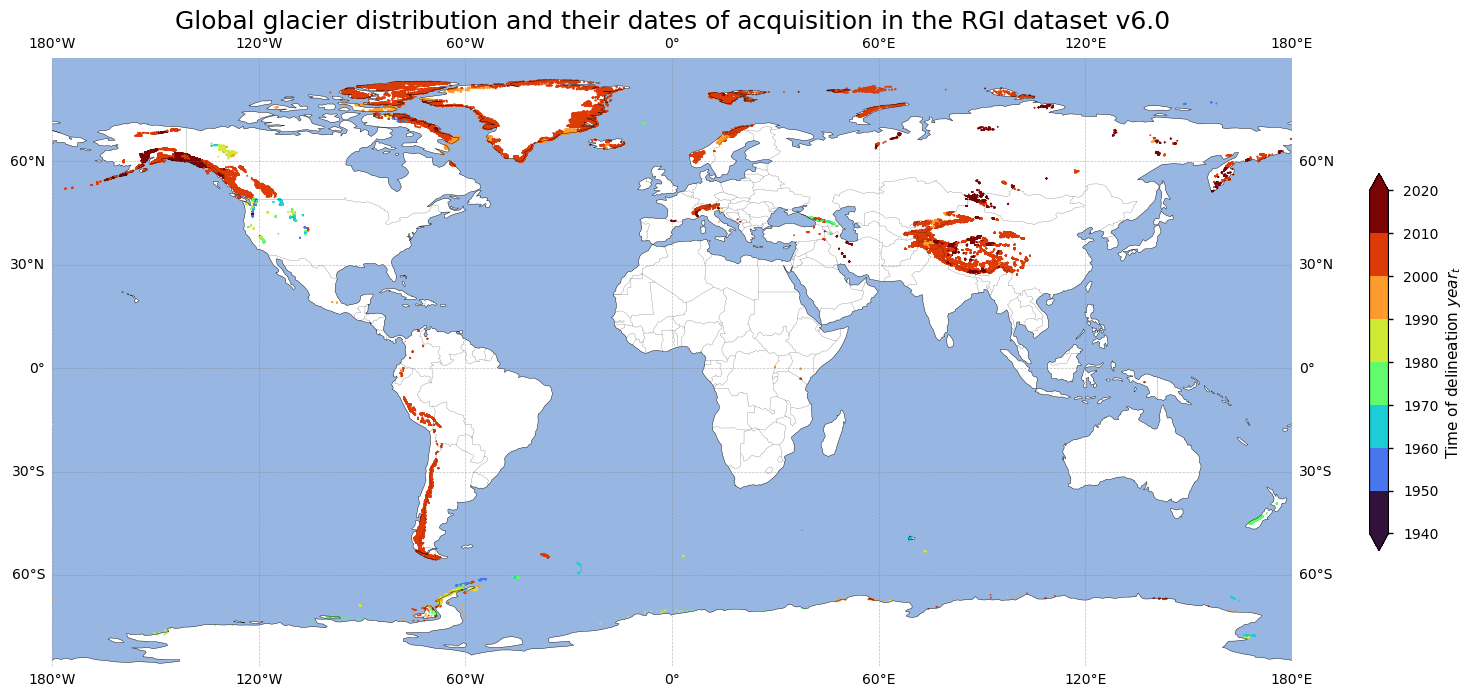

In [128]:
# First map

cmap = mpl.cm.turbo
def round_up_to_10(num):
    return math.ceil(num / 10) * 10
year2 = year.dropna()
year_rounded_up = year2.apply(round_up_to_10)
norm = mpl.colors.BoundaryNorm(range(np.min((year // 10) * 10), np.max(year_rounded_up)+1, 10), cmap.N)
ax = plot_map(
    gdf,
    var_name="year",
    cmap=cmap,
    norm=norm,
    label=r"Time of delineation $year_t$",
    title=f"Global glacier distribution and their dates of acquisition in the RGI dataset v{rgi_version}",
)

*<center>Figure 2. Spatial distribution of the time of delineation (date of acquisition) for the glaciers in the glacier extent dataset.</center>*

From the above plots, it becomes clear that not all glaciers are delineated in the year 2000. Although the dataset is intended to be a snapshot of the world’s glaciers as they were near the beginning of the 21$^{st}$ century, the user must keep in mind that the range of delineation dates is substantial. This means that the outlines do not all lie in between the same time frame, which is a main issue of the dataset. The figures above, however, demonstrate that most outlines originate from the period between 2000 and 2010. Nevertheless, for some areas like the western United States or some peripheral glaciers around northern Greenland and the Antarctic Penninsula, the glacier outlines date back to the 1970s or earlier. 

(satellite_insitu-glaciers-extent_uncertainty_q01:section-2-3)=
#### 2.3 The (area-weighted) mean year of delineation per RGI region

Let us now calculate the (area-weighted) mean time of delineation for the 19 different RGI regions (see Figure 5 for the locations of these regions). We do that as follows:

- Arithmetic mean:
$
\overline{year}_a = \textstyle\dfrac{1}{{n\in \text{region}}}{\sum\limits_{i=1}^{n\in \text{region}} year_{t,i}}
$
with 
$
n
$
the total number of glaciers and $year_t$ the time of delineation for glacier $i$ as calculated above.

- Area-weighted mean:
$
\overline{year}_w = \left(\dfrac{1}{\sum\limits_{i=1}^{n\in \text{region}} A_i}\right) \sum\limits_{i=1}^{n\in \text{region}} \left(A_i * year_{t,i}\right)
$
where
$
A_i
$
is the glacier area for glacier $i$ [km²].

This results in the following plot:

The global arithmetic mean year of delineation (RGI v6.0) is 2002.8.
The global area-weighted mean year of delineation (RGI v6.0) is 2001.3.


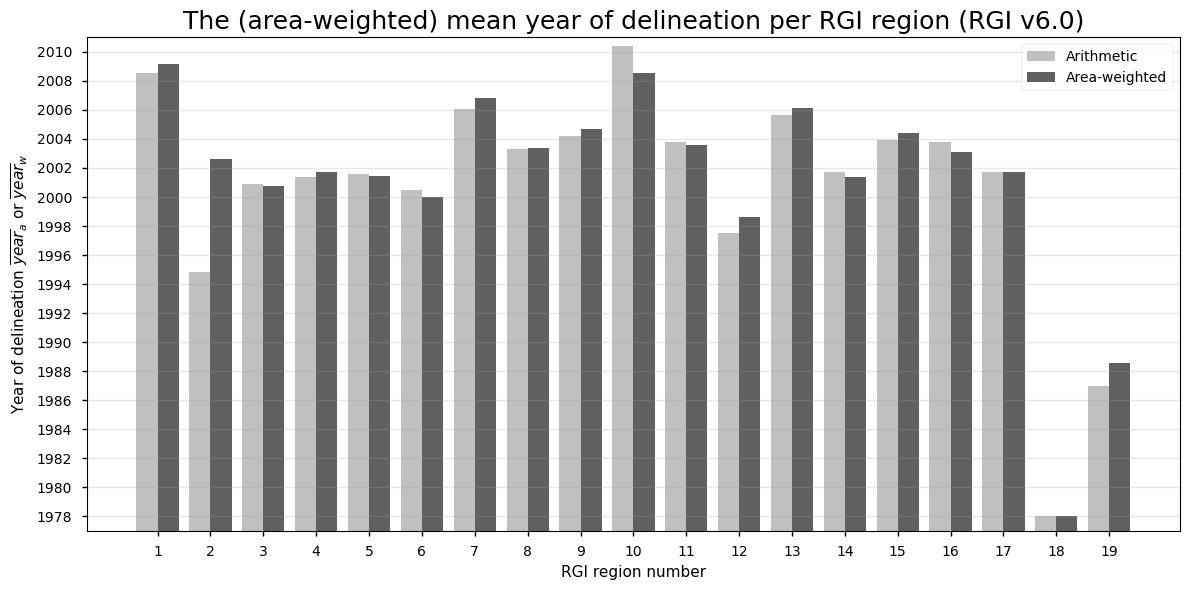

In [129]:
if rgi_version == 6.0:
    # Extract region number from RGIID
    gdf["region"] = gdf["RGIID"].str[6:8].astype(int)

    # Group by region and calculate total area
    grouped = gdf[["year", "decimal_year", "AREA", "region"]].groupby("region")
    ungrouped = gdf[["year", "decimal_year", "AREA", "region"]]
    total_area = grouped["AREA"].sum()

    # Calculate means
    means = {
        "Arithmetic": grouped["decimal_year"].mean(),
        "Area-weighted": grouped.apply(
            weighted_average, "decimal_year", "AREA", include_groups=False
        ),
    }
elif rgi_version == 7.0:
    # Extract region number from o1region
    gdf["region"] = gdf["o1region"].astype(int)

    # Group by region and calculate total area
    grouped = gdf[["year", "decimal_year", "area_km2", "region"]].groupby("region")
    ungrouped = gdf[["year", "decimal_year", "area_km2", "region"]]
    total_area = grouped["area_km2"].sum()

    # Calculate means
    means = {
        "Arithmetic": grouped["decimal_year"].mean(),
        "Area-weighted": grouped.apply(
            weighted_average, "decimal_year", "area_km2", include_groups=False
        ),
    }

# Ensure regions are correctly defined as an array
regions = np.array(list(grouped.groups.keys()))  # Extract regions as a sorted array

# Extract the means
arithmetic_means = means["Arithmetic"]
area_weighted_means = means["Area-weighted"]

# Define bar width and positions
bar_width = 0.4
r1 = regions - bar_width / 2  # Positions for arithmetic bars
r2 = regions + bar_width / 2  # Positions for area-weighted bars

textstr = '\n'.join((
    'The global arithmetic mean year of delineation (RGI v{:.1f}) is {:.1f}.'.format(rgi_version, gdf["decimal_year"].mean()),
    'The global area-weighted mean year of delineation (RGI v{:.1f}) is {:.1f}.'.format(rgi_version, means["Area-weighted"].mean()),
))
print(textstr)

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(r1, arithmetic_means, width=bar_width, color=(192/255, 192/255, 192/255), label='Arithmetic')
plt.bar(r2, area_weighted_means, width=bar_width, color=(96/255, 96/255, 96/255), label='Area-weighted')

# Add labels, title, and legend
plt.xlabel("RGI region number")
plt.ylabel(r"Year of delineation $\overline{year}_a$ or $\overline{year}_w$")
plt.title("The (area-weighted) mean year of delineation per RGI region (RGI v{})".format(rgi_version), fontsize=18)
plt.xticks(regions)  # Ensure x-ticks match region numbers
plt.ylim(1977, 2011)  # Replace 1980 and 2020 with your desired range
plt.legend()

# Add grid and show plot
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.grid(
    which='major',
    axis='y',
    color='#95a5a6',
    linestyle='-',
    alpha=0.25
)
plt.tight_layout()
plt.show()

*<center>Figure 3. Arithmetic and area-weighted mean year of delineation for the glaciers in each RGI region of the glacier extent dataset.</center>*

We observe that at the global scale, the arithmetic area-weighted average of the year of delineation is close to 2002, which only slightly differs in time from the nominally stated dataset reference time (i.e. 2000). However, the (area-weighted) average of the time of delineation varies notably across the different RGI regions: for RGI region 18, for example, the area-weighted average dates back to the late 1970s, but for RGI regions 1 and 10, the average origin dates are closer to the 2010s.

(satellite_insitu-glaciers-extent_uncertainty_q01:section-3)=
### 3. Estimation of global glacier ice volumes around the year 2000 with RGI data

(satellite_insitu-glaciers-extent_uncertainty_q01:section-3-1)=
#### 3.1 Recent glacier area and mass/volume change trends

Going back to our specific use case, it is worth noting that several methods exist in the literature to derive ice thickness and ice volume estimates of glaciers at different spatial scales, of which the most well-known procedures are the volume-area scaling method, numerical modelling, and the estimation of ice thicknesses from surface characteristics and the principle of ice dynamics. These methods, however, strongly rely on the precise determination of the glacier surface area (and hypsometry) as input data to derive total ice volume estimates. 

Farinotti et al. (2019), for example, used the RGIv6.0 dataset to derive a global glacier ice volume of 158.17 ± 41.03 × 10³ km³, noting the heavy reliance on accurate glacier surface area data [[3](https://doi.org/10.1038/s41561-019-0300-3)]. Other studies, including Huss and Farinotti (2012), Marzeion et al. (2012) and GlaMBIE (2025), have similarly highlighted input data uncertainties with respect to the glacier area in ice volume estimates [[4](https://doi.org/10.1029/2012JF002523), [5](https://doi.org/10.5194/tc-6-1295-2012), [14](https://doi.org/10.1038/s41586-024-08545-z)]. The main concern here is that the glacierized area has decreased significantly during the last several decades, with global glacier area decreasing at rates of -0.18% to -0.34% per year and median retreat rates of 7.4 m per year [[6](https://doi.org/10.3189/2015JoG15J017), [7](https://doi.org/10.1016/j.accre.2020.03.003), [8](https://doi.org/10.5194/tc-8-659-2014)]. These changes suggest a potential overestimation of volumes for glaciers delineated before 2000 and an underestimation elsewhere. The suitability of RGI outlines for current volume estimates therefore primarily depends on (1) the deviation of the time since delineation of the outline from 2000 and (2) the significance of glacier area/volume changes during that period, which are influenced by the local climate and specific glacier geometries.

Let us plot the regional glacier mass changes for the different RGI regions from the "[Glacier mass change gridded data from 1976 to present derived from the Fluctuations of Glaciers Database](https://cds.climate.copernicus.eu/datasets/derived-gridded-glacier-mass-change?tab=overview)" dataset on the CDS:

In [130]:
if rgi_version == 6.0:
    # Mask data for RGI regions
    regions = gdf["RGIID"].str[6:8].astype(int)
    da = regions.to_xarray().assign_coords(
        lon=gdf["CENLON"].to_xarray(),
        lat=gdf["CENLAT"].to_xarray(),
    )
elif rgi_version == 7.0:
    # Mask data for RGI regions
    regions = gdf["o1region"].astype(int)
    da = regions.to_xarray().assign_coords(
        lon=gdf["cenlon"].to_xarray(),
        lat=gdf["cenlat"].to_xarray(),
    )
regridder = xe.Regridder(da, ds, locstream_in=True, method="nearest_s2d")
mask_2d = regridder(da)
mask = xr.concat(
    [(mask_2d == region).expand_dims(region=[region]) for region in regions.unique()],
    "region",
)
ds = ds.where(mask)

# Compute cumulative fields
ds["time"].attrs |= {"long_name": "Time", "units": "yr"}
for da in ds.data_vars.values():
    da.attrs["units"] += " $yr^{-1}$"
    da.attrs["long_name"] = da.attrs["long_name"].replace("_", " ").title()

# Mass change
cumulative = (ds["glacier_mass_change_gt"].sum(("latitude","longitude"),keep_attrs=True)).cumsum("time")
cumulative.attrs = {
    "units": ds["glacier_mass_change_gt"].attrs["units"].split()[0],
    "long_name": f"Cumulative {ds['glacier_mass_change_gt'].attrs['long_name']}",
}
ds["Cumulative"] = cumulative

# Select first and last year explicitly (robust)
cum_1976 = ds["Cumulative"][0]
cum_2022 = ds["Cumulative"][-1]

# Total mass change per region
total_change = (cum_2022 - cum_1976).compute()

for region in total_change.region.values:
    dM = float(total_change.sel(region=region).values)

    print(
        f"The total glacier mass change in RGI region {int(region)} "
        f"between 1976 and 2022 is {dM:.2f} Gt."
    )

The total glacier mass change in RGI region 1 between 1976 and 2022 is -2445.24 Gt.
The total glacier mass change in RGI region 2 between 1976 and 2022 is -370.94 Gt.
The total glacier mass change in RGI region 3 between 1976 and 2022 is -889.74 Gt.
The total glacier mass change in RGI region 4 between 1976 and 2022 is -794.43 Gt.
The total glacier mass change in RGI region 5 between 1976 and 2022 is -675.07 Gt.
The total glacier mass change in RGI region 6 between 1976 and 2022 is -263.90 Gt.
The total glacier mass change in RGI region 7 between 1976 and 2022 is -424.88 Gt.
The total glacier mass change in RGI region 8 between 1976 and 2022 is -36.70 Gt.
The total glacier mass change in RGI region 9 between 1976 and 2022 is -404.35 Gt.
The total glacier mass change in RGI region 10 between 1976 and 2022 is -50.55 Gt.
The total glacier mass change in RGI region 11 between 1976 and 2022 is -45.34 Gt.
The total glacier mass change in RGI region 12 between 1976 and 2022 is -16.86 Gt.
The 

The above emphasizes the strong negative glacier mass change trends that have been observed across the globe. It, however, creates a systematic bias when using the RGI data for the estimation of regional and global glacier volumes if the acquisition date does not coincide with the year 2000. Let us try to quantify this error with all of the information above.

(satellite_insitu-glaciers-extent_uncertainty_q01:section-3-2)=
#### 3.2 An attempt to quantify potential glacier volume over or underestimation

It is difficult to quantify the potential volume over or underestimation due to deviating outlines for each glacier in the dataset. However, we can get an idea of the regional glacier  volume under/overestimation for 2000 CE by using the glacier mass change dataset that is available on the CDS. Our goal here is to obtain values for the regional glacier volume change between the year 2000 and the area-weighted mean year of delineation of that region $\overline{year}_w$ (which is thus equivalent to the potential volume over or underestimation relative to the year 2000), denoted with the symbol $dV_{\text{region}}^{2000,\overline{\text{year}}_w}$. 

To get an idea of these potential glacier volume over- or underestimations, we can make use of the glacier mass change dataset that is on the CDS. This dataset estimates the gridded yearly mass change of glacier ice ($dM/dt$) in Gt yr$^{-1}$, which can be converted to glacier volume changes ($dV/dt$) with units of km$^3$ yr$^{-1}$ of ice by making use of the appropriate density. We thus calculate the mass and volume change between 2000 and the area-weighted average year of delineation for a certain RGI region ($\overline{year}_w$) to get a total volume change for that specific RGI region between those two dates $dV_{\text{region}}^{2000,\overline{year}_w}$. If ${{\overline{year}_w}}$ is a decimal (fractional) year, we use linear interpolation to find the interpolated glacier mass and volume change: 

$ 
dV_{\text{region}}^{2000,\overline{year}_w} \text{ [km}^3\text{]} = 
\begin{cases} 
\left(\sum\limits_{i=2000}^{\lceil \overline{year}_w \rceil} \sum\limits^{\substack{\text{x,y} \\ \text{{region}}}} \left(\frac{1000}{\rho_i} \frac{dM}{dt}\right)\right) - \\ \left[ \left( \lceil \overline{year}_w \rceil - \overline{year}_w \right) * \left( \sum\limits^{\substack{\text{x,y} \\ \text{region}}} \left(\frac{1000}{\rho_i} \frac{dM}{dt}\right)_{\lceil \overline{year}_w \rceil} \right) \right] & \text{if } \overline{year}_w > 2000 \\ 
\left(\sum\limits_{i=\lfloor \overline{year}_w \rfloor}^{2000} \sum\limits^{\substack{\text{x,y} \\ \text{region}}} \left(\frac{1000}{\rho_i} \frac{dM}{dt}\right)\right) - \\ \left[ \left( \overline{year}_w - \lfloor \overline{year}_w \rfloor \right) * \left( \sum\limits^{\substack{\text{x,y} \\ \text{region}}} \left(\frac{1000}{\rho_i} \frac{dM}{dt}\right)_{\lfloor \overline{year}_w \rfloor} \right) \right] & \text{if } \overline{year}_w < 2000 
\end{cases} 
$

Basically, this comes down to "reprojecting" glacier volumes back to the year 2000 from the area-weighted year of data acquisition by making use of known glacier changes in between these two dates. Here, we further assume a density $\rho_i$ of 900 kg m$^{-3}$ for the mass to volume conservation of glaciers, as also chosen by Farinotti et al. (2019) [[3](https://doi.org/10.1038/s41561-019-0300-3), [9](https://doi.org/10.5194/tc-7-877-2013)]. This may look like a complicated formula, but the principle is simple: for each RGI region, we simply sum the mass (and hence volume) changes over all spatial pixels between the year 2000 and the area-weighted year of delineation $(\overline{year}_w)$:
- If $(\overline{year}_w)$ is an integer, the second part of the formula (after the minus sign) drops out.
- If $(\overline{year}_w)$ is not an integer, the formula adjusts for the fractional part of the year:
  - If $(\overline{year}_w)$ > 2000, it uses the fraction between $(\overline{year}_w)$ and $(\lceil \overline{year}_w \rceil)$, where $\lceil \cdot \rceil$ denotes the ceiling function, which rounds a number up to the nearest integer.
  - If $(\overline{year}_w)$ < 2000, it uses the fraction between $(\lfloor \overline{year}_w \rfloor)$ and $(\overline{year}_w)$, where $\lfloor \cdot \rfloor$ denotes the floor function, which rounds a number down to the nearest integer.

Now that we have all information to derive values for $ dV_{\text{region}}^{2000,\overline{year}_w}$, let us apply this to the 19 different RGI regions in the RGIv7.0 data:

In [131]:
# Calculate volume under or overestimation
year = 2000
rho_i = 900  # Ice density

original = ds.reset_coords()["Cumulative"]
time = original["time"]
original["time"] = time.dt.year + (time.dt.dayofyear - 1) / (365 + time.dt.is_leap_year)

interpolated = original.interp(
    time=means["Area-weighted"].to_xarray()
)

estimate = (1000 / rho_i) * (
    interpolated - original.sel(time=year)
).compute()

# Printing loop 
for region, result in zip(out.region.values, out["estimate"].values):
    print(
        f"The volume estimate in RGI region {region:>2}"
        f" for the year {year} is"
        f" {'under' if result < 0 else 'over':>5}estimated"
        f" by {abs(float(result)):.2f} km³."
    )

total = out["estimate"].sum()
print(
    f"\nThe volume estimate at the global scale"
    f" for the year {year} is"
    f" {'under' if total < 0 else 'over'}estimated"
    f" by {abs(float(total)):.2f} km³."
)

The volume estimate in RGI region  1 for the year 2000 is underestimated by 531.53 km³.
The volume estimate in RGI region  2 for the year 2000 is underestimated by 27.16 km³.
The volume estimate in RGI region  3 for the year 2000 is underestimated by 14.62 km³.
The volume estimate in RGI region  4 for the year 2000 is underestimated by 21.82 km³.
The volume estimate in RGI region  5 for the year 2000 is underestimated by 34.71 km³.
The volume estimate in RGI region  6 for the year 2000 is underestimated by 0.07 km³.
The volume estimate in RGI region  7 for the year 2000 is underestimated by 85.89 km³.
The volume estimate in RGI region  8 for the year 2000 is underestimated by 11.39 km³.
The volume estimate in RGI region  9 for the year 2000 is underestimated by 74.83 km³.
The volume estimate in RGI region 10 for the year 2000 is underestimated by 9.88 km³.
The volume estimate in RGI region 11 for the year 2000 is underestimated by 5.09 km³.
The volume estimate in RGI region 12 for the 

Or when plotted:

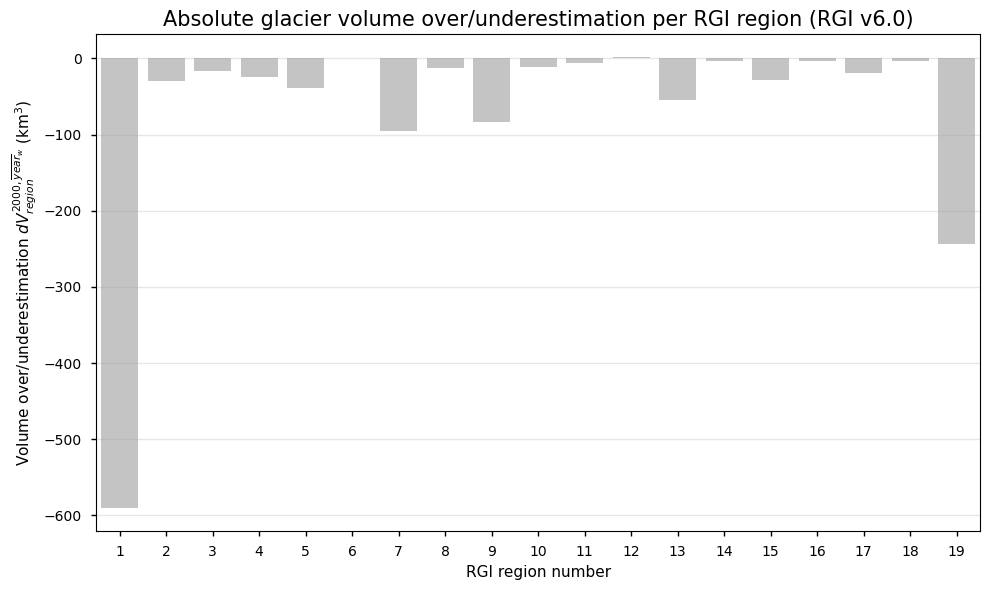

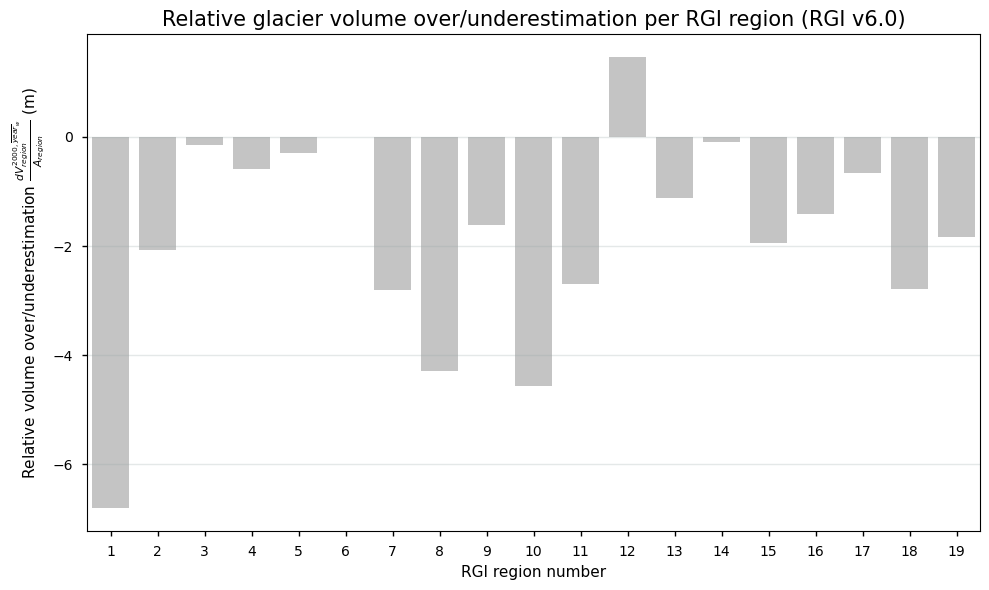

In [140]:
# Area-weighted estimate
estimate_weighted = 1000*(estimate/total_area)

# Plot 1 — Raw estimates
regions = estimate.region.values

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    regions,
    estimate.values,
    color=(196/255,196/255,196/255),
)

ax.set_xlabel("RGI region number")
ax.set_ylabel(
    r"Volume over/underestimation "
    r"$dV_{region}^{2000,\overline{year}_w}$ (km$^3$)"
)
ax.set_title(
    f"Absolute glacier volume over/underestimation per RGI region (RGI v{rgi_version})",
    fontsize=15,
)

ax.set_xticks(regions)
ax.set_xlim(regions.min() - 0.5, regions.max() + 0.5)
ax.grid(color="#95a5a6", linestyle="-", alpha=0.25, axis="y")

plt.tight_layout()
plt.show()

# Plot 2 — Area-weighted
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    regions,
    estimate_weighted.values,
    color=(196/255,196/255,196/255),
)

ax.set_xlabel("RGI region number")
ax.set_ylabel(
    r"Relative volume over/underestimation "
    r"$\frac{dV_{region}^{2000,\overline{year}_w}}{A_{region}}$ (m)"
)
ax.set_title(
    f"Relative glacier volume over/underestimation per RGI region (RGI v{rgi_version})",
    fontsize=15,
)

ax.set_xticks(regions)
ax.set_xlim(regions.min() - 0.5, regions.max() + 0.5)
ax.grid(color="#95a5a6", linestyle="-", alpha=0.25, axis="y")

plt.tight_layout()
plt.show()

*Figure 4. Total (above) and relative, i.e. volume divided by the total glacier surface area, (below) volume over or underestimation compared to the year 2000 for the glaciers in each RGI region of the glacier extent dataset.*

In the plot above, negative values indicate an underestimation. Underestimations of glacier volumes are noted in all but one regions, which is because the (area-weighted) average origin dates of the outlines are generally later than 2000, together with a general trend of glacier shrinkage during the last several decades [[6](https://doi.org/10.3189/2015JoG15J017)]. It is clear that especially RGI regions 1 (Alaska) and 19 (Antarctic and Subantarctic) exhibit a relatively large underestimation of the total glacier ice volume, mainly due to their large deviation of the area-weighted average year of delineation to the year 2000, as well as the large glacier ice volume changes during this corresponding period. Even though the largest temporal deviation of acquisition dates is noted for RGI region 18 (New Zealand), the total volume underestimation is not significant due to the relatively small glacier changes. 

At the global scale, glacier ice volume estimates would exhibit an underestimation of ca. 1150 km³ due to misdated glacier outlines, which is only ca. 0.75% and 0.85% of the total glacier ice volume estimate by Farinotti et al. (2019) and GlaMBIE (2025) respectively [[3](https://doi.org/10.1038/s41561-019-0300-3), [14](https://doi.org/10.1038/s41586-024-08545-z)]. At the global scale, the above obtained deviation related to the misdated glacier outlines from RGIv6.0 is thus relatively low when compared to the total global glacier ice volume estimate from the glacier community, implying that the dataset is well-suited to estimate current global glacier ice volumes for the year 2000. The corresponding systematic error is thus small, but glacier- and region-dependent.

![alternatvie text](https://www.glims.org/rgi_user_guide/_images/global_map_small.jpeg)

*Figure 5. The 19 first-order regions of the RGI version 7.0 and glacier locations in red. From: [GLIMS RGI](https://www.glims.org/rgi_user_guide/welcome.html).*

(satellite_insitu-glaciers-extent_uncertainty_q01:section-3-3)=
#### 3.3 Other potential sources of error and uncertainty

Several additional factors contribute to the uncertainty in glacier data derived from the RGI dataset. These include low-resolution and poor-quality source data, errors by delineators, and challenges such as shadows, clouds, proglacial lakes, seasonal snowfields, and limited multi-temporal satellite imagery. The most significant source of misdelineation is, however, supraglacial debris, which often results in glacier area underestimation in regions with extensive debris cover (e.g. High Mountain Asia and the Caucasus), due to the spectral similarity between debris and surrounding moraines or bedrock [[10](https://doi.org/10.3189/2013AoG63A296)]. Additionally, ice bodies smaller than 0.01 km², considered below the threshold for ice flow, were excluded, leading to further underestimation of glacier area in some regions [[1](https://www.glims.org/RGI/randolph60.html)].

The interpretation of what constitutes a glacier also varies due to the diverse global community that contributed to the dataset, causing inconsistencies in how features like debris-covered glaciers, tributaries, and peripheral ice bodies in Antarctica and Greenland were handled [[11](https://doi.org/10.1017/jog.2023.1)]. For example, distinguishing debris-covered ice from bedrock or separating outlet glaciers from main ice sheets remains problematic. Other problems are related to geolocation issues, outline artefacts, and ice divides at wrong locations.

Quantitative error estimates are not provided with the downloaded data, but [[2](https://doi.org/10.3189/2014JoG13J176)] noted that relative errors are higher for small glaciers due to their larger outline-to-area ratio. Consequently, the uncertainty in an individual glacier outline depends on the quality of the source material and the specific glacier's characteristics. Users should thus exercise caution, particularly in regions with significant debris cover, small glacier features or around the peripheral glaciers of the Greenland and Antarctic ice sheets (where a clear separation of outlet glaciers from the main ice sheet body may be difficult).

Although this notebook makes use of the RGIv6.0, some notable improvements have been made in the newer RGIv7.0 with respect to area and mapping year estimates. This has ensured that the quality of outlines has substantially improved in many regions due to, amongst others, the inclusion of new updated inventory data and a new largely automated workflow. For example, 35% of all RGIv6.0 outlines were dated to five or more years away from the target year 2000, while this number is down to 23% in RGIv7.0. It is therefore advised for users to utilize the RGIv7.0 in future assessments.

(satellite_insitu-glaciers-extent_uncertainty_q01:section-4)=
### 4. Short summary and take-home messages

The RGI glaciers distribution dataset that is on the CDS is currently the most complete dataset of glacier (and ice cap) outlines, outside of the Greenland and Antarctic Ice Sheets, in terms of its spatial coverage. It aims to capture the spatial distribution and global state of glacier outlines representative for the year 2000. However, the date of delineation (i.e. the time for which the outlines are representative) can significantly deviate from 2000, resulting in a systematic error. 

When using the data for certain applications, such as for quantifying current global glacier volumes with RGI glacier areas as input data, this sytematic error has to be taken into account. It is found that the suitability of a RGI outline for current glacier ice volume estimates hence depends on (1) the deviation of the time since delineation from 2000 and (2) the significance of glacier area/volume changes during that period, which are influenced by changes of the local climate and the specific glacier geometries. Nevertheless, the assessment in this notebook revealed that (area-weighted) mean acquisition date of the glacier outlines is relatively close to 2000 at the global scale, although a tendency for delineation dates that are slightly more recent than 2000 is noted. Moreover, when compared to the total global ice volume estimate by Farinotti et al. (2019) and GlaMBIE (2025) [[3](https://doi.org/10.1038/s41561-019-0300-3), [14](https://doi.org/10.1038/s41586-024-08545-z)], the resulting systematic error calculated in this notebook is in the order of <1% only. This makes the dataset reliable to be used as input data for current global glacier volume estimates, but the systematic error is glacier- and region-dependent. 

Additional factors to take into account are, amongst others, supraglacial debris, which often leads to an underestimation of the glacierized area in highly debris-covered regions such as High Mountain Asia and the Caucasus. When fed into glaciological and/or hydrological models, users are thus advized to take into account these considerations.

## ℹ️ If you want to know more

### Key resources

- [Glaciers distribution data from the Randolph Glacier Inventory (RGI) for year 2000](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview)
- [Documentation on the CDS](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/display/CKB/Glacier+Area)
- [Copernicus climate change indicators: glaciers](https://climate.copernicus.eu/climate-indicators/glaciers)
- [RGI website from GLIMS](https://www.glims.org/RGI/) (Global Land Ice Measurements from Space)
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control` prepared by [B-Open](https://www.bopen.eu).

### References

- [[1](https://www.glims.org/RGI/randolph60.html)] RGI Consortium (2017). Randolph Glacier Inventory – A Dataset of Global Glacier Outlines: Version 6.0: Technical Report, Global Land Ice Measurements from Space, Colorado, USA. Digital Media. doi: 10.7265/N5-RGI-60.

- [[2](https://doi.org/10.3189/2014JoG13J176)] Pfeffer, W. T., Arendt, A. A., Bliss, A., Bolch, T., Cogley, J. G., Gardner, A. S., Hagen, J. O., Hock, R., Kaser, G., Kienholz, C., Miles, E. S., Moholdt, G., Mölg, N., Paul, F., Radić, V., Rastner, P., Raup, B. H., Rich, J., Sharp, M. J., and Glasser, N. (2014). The Randolph Glacier Inventory: A globally complete inventory of glaciers, Journal of Glaciology, 60(221), 537-552. doi: 10.3189/2014JoG13J176.

- [[3](https://doi.org/10.1038/s41561-019-0300-3)] Farinotti, D., Huss, M., Fürst, J. J., Landmann, J., Machguth, H., Maussion, F., and Pandit, A. (2019). A consensus estimate for the ice thickness distribution of all glaciers on Earth. Nature Geoscience, 12(3), 168-173. doi: 10.1038/s41561-019-0300-3.

- [[4](https://doi.org/10.1029/2012JF002523)] Huss, M., and Farinotti, D. (2012). Distributed ice thickness and volume of all glaciers around the globe, Journal of Geophysical Research, 117, F04010. doi: 10.1029/2012JF002523.

- [[5](https://doi.org/10.5194/tc-6-1295-2012)] Marzeion, B., Jarosch, A. H., and Hofer, M. (2012). Past and future sea-level change from the surface mass balance of glaciers, The Cryosphere, 6, 1295–1322. doi: 10.5194/tc-6-1295-2012.

- [[6](https://doi.org/10.3189/2015JoG15J017)] Zemp, M., Frey, H., Gärtnew-Roer, I., Nussbaumer, S. U., Helzle, M., Paul, F., Haeberli, W., Denzinger, F., Ahlstrøm, A. P., Anderson, B., Bajracharya, S., Baroni, C., Braun, L. N., Cáceres, B. E., Casassa, G., Cobos, G., Dávila, L. R., Delgado Granados, H., Demuth, M. N., Espizua, L., Fischer, A., Fujita, K., Gadek, B., Ghazanfar, A., Hagen, J. O., Holmlund, P., Karimi, N., Li, Z., Pelto, M., Pitte, P., Popovnin, V. V., Portocarrero, C. A., Prinz, R., Sangewar, C. V., Severskiy, I., Sigurdsson, O., Soruco, A., Usubaliev, R., and Vincent, C. (2015). Historically unprecedented global glacier decline in the early 21st century, Journal of Glaciology, 61, 745-762. doi: 10.3189/2015JoG15J017.

- [[7](https://doi.org/10.1016/j.accre.2020.03.003)] Li, Y. J., Ding, Y. J., Shangguan, D. H., and Wang, R. J. (2019). Regional differences in global glacier retreat from 1980 to 2015, Advances in Climate Change Research, 10(4), 203–213. doi: 10.1016/j.accre.2020.03.003.

- [[8](https://doi.org/10.5194/tc-8-659-2014)] Leclercq, P. W., Oerlemans, J., Basagic, H. J., Bushueva, I., Cook, A. J., and Le Bris, R. (2014). A data set of worldwide glacier length fluctuations, Cryosphere, 2014(8), 659–672. doi: 10.5194/tc-8-659-2014.

- [[9](https://doi.org/10.5194/tc-7-877-2013)] Huss, M. (2013). Density assumptions for converting geodetic glacier volume change to mass change, The Cryosphere, 7, 877–887, doi: 10.5194/tc-7-877-2013.

- [[10](https://doi.org/10.3189/2013AoG63A296)] Paul, F., Barrand, N. E., Baumann, S., Berthier, E., Bolch, T., Casey, K., Frey, H., Joshi, S. P., Konovalov, V., Le Bris, R., Mölg, N., Nosenko, G., Nuth, C., Pope, A., Racoviteanu, A., Rastner, P., Raup, B., Scharrer, K., Steffen, S., and Winsvold, S. (2013). On the Accuracy of Glacier Outlines Derived from Remote-Sensing Data. Annals of Glaciology, 54(63), 171–82. doi: 10.3189/2013AoG63A296.

- [[11](https://doi.org/10.1017/jog.2023.1)] Hock, R., Maussion, F., Marzeion, B., and Nowicki, S. (2022). What is the global glacier ice volume outside the ice sheets? Journal of Glaciology, 69(273), 204–10. doi: 10.1017/jog.2023.1.

- [[12](https://doi.org/10.1017/jog.2021.28)] Li, Y. J., Li, F., Shangguan, D. H., Ding, Y. J. (2021). A New Global Gridded Glacier Dataset Based on the Randolph Glacier Inventory Version 6.0. Journal of Glaciology, 67 (2021), 773–76. doi: 10.1017/jog.2021.28.

- [[13](https://doi.org/10.5194/tc-6-1483-2012)] Rastner, P., Bolch, T., Mölg, N., Machguth, H., Le Bris, R., and Paul, F. (2012). The first complete inventory of the local glaciers and ice caps on Greenland, The Cryosphere, 6, 1483–1495, https://doi.org/10.5194/tc-6-1483-2012

- [[14](https://doi.org/10.1038/s41586-024-08545-z)] The GlaMBIE Team (2025). Community estimate of global glacier mass changes from 2000 to 2023. Nature 639, 382–388. https://doi.org/10.1038/s41586-024-08545-z